In [488]:
import numpy as np
import pandas as pd

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
sys.path.append("../../..")


import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso 
from sklearn.decomposition import PCA #USE PCA FOR PCR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime
import math
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [489]:
# Link for NFL Attendance Data: https://docs.google.com/spreadsheets/d/1DRMB5FLC3tdngeurDwps1CS8-6smEZvmq5R-ghjEv5k/edit#gid=0


#Import NFL Attendance Data using Pandas
attendance_df = pd.read_csv('NFL_Data.csv')

#Lots of NaN values, remove values without 'Team'
attendance_df = attendance_df.loc[~attendance_df['Team'].isnull()]

#Import NFL stadium County data, along with Neutral Counties
stadium_county_df = pd.read_csv('Stadium_County.csv',header=1) #Data is a little bit Messy 


#County Covid Rates Provided from NYTIMES Github Database, https://github.com/nytimes/covid-19-data/blob/master/us-counties-2020.csv
county_covid = pd.read_csv('County_Covid_Data.csv')


stadium_county_df['Team '].fillna(method = 'ffill', inplace= True)
stadium_county_df.rename(columns={'Team ': 'Team'}, inplace=True)
county_covid['date'] = pd.to_datetime(county_covid['date'])
county_covid = county_covid.loc[~(county_covid['county'] == 'Unknown')]
county_covid = county_covid.loc[~(county_covid['cases'].isnull())]


#We want to use stadium_county_df to find buffer counties and stadium counties and neutral counties. 
stadium_county_df

,Team,First date home stadium open to fans,County(s),State,% fans,Counties,State.1,% fans.1,Unnamed: 8
0,Arizona,10/25/2020,COUNTY DATA NOT AVAILABLE,NaN,NaN,NaN,NaN,NaN,NaN
1,Atlanta,10/25/2020,Fulton,GA,18.63,Cobb,GA,8.24,"April 12, 2020: Our database changed to exclud..."
2,Atlanta,NaN,NaN,NaN,NaN,Dekalb,GA,7.84,NaN
3,Atlanta,NaN,NaN,NaN,NaN,Gwinnett,GA,7.05,NaN
4,Atlanta,NaN,NaN,NaN,NaN,Hall,GA,2.49,NaN
...,...,...,...,...,...,...,...,...,...
180,Tennessee,NaN,NaN,NaN,NaN,Warren,KY,1.23,NaN
181,Tennessee,NaN,NaN,NaN,NaN,Knox,TN,1.17,NaN
182,Tennessee,NaN,NaN,NaN,NaN,Cook,IL,1.01,NaN
183,Tennessee,NaN,NaN,NaN,NaN,Cheatham,TN,1.01,NaN


In [490]:
#We want to fill in state/county Data for cities that don't have stadium counties listed. Go through 1 by 1
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'State'] = 'AZ'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'State'] = 'IL'

stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'State'] = 'MI'

stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'State'] = 'NV'

stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'State'] = 'MN'

stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'State'] = 'MA'

stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'State'] = 'LA'

stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'State'] = 'NJ'

stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'State'] = 'NJ'

stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'State'] = 'WA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'State'] = 'District of Columbia'

stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'County(s)'] = 'Maricopa'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'County(s)'] = 'Cook'
stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'County(s)'] = 'Wayne'
stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'County(s)'] = 'Clark'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'County(s)'] = 'Ramsey'
stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'County(s)'] = 'Norfolk'
stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'County(s)'] = 'Orleans'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'County(s)'] = 'Santa Clara'
stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'County(s)'] = 'King'
stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'County(s)'] = 'District of Columbia'

In [491]:
home_state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [492]:

#We want to associate NFL teams to their respective Counties. Add Column that contains 'HOME COUNTIES', and columns that contains 'NEUTRAL COUNTIES'

#attendance_df['Team City'] = attendance_df.Team.str.split().str[:-1].str.join(sep=' ') #To connect with county information


#Change exceptions with 2 name cities



def find_stadium_counties(team_city_str):
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    #team_city_data = team_city_data[team_city_data['County(s)'].notnull()]
    
    #Take away counties that don't belong in home state
    home_state = list(team_city_data['State'])[0]
    team_city_data = team_city_data[team_city_data['State.1'] == home_state]
    
    if team_city_str in no_fans_list:
        #If no fans, there actually is NO stadium county, since they are *not* affected by opening stadium. 
        return ""
    
    return list(set(team_city_data['County(s)']))

def find_donor_counties(team_city_str): #All counties within the state that is NOT in buffer counties.
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    team_city_data = team_city_data[team_city_data['Counties'].notnull()]
    
    #Take away counties that don't belong in home state
    if(len(list(team_city_data['State'])) > 0): #If a home state exists... some not included in data set
        home_state = list(team_city_data['State'])[0]
    else: #Exceptions
        if team_city_str == 'Arizona':
            home_state = "AZ"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'Detroit':
            home_state = "MI"
        elif team_city_str == 'Las Vegas':
            home_state = "NV"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'LA Chargers':
            home_state = "CA"
        elif team_city_str == 'LA Rams':
            home_state = "CA"
        elif team_city_str == 'Minnesota':
            home_state = "MN"
        elif team_city_str == 'New England':
            home_state = "MA"
        elif team_city_str == 'New Orleans':
            home_state = "LA"
        elif team_city_str == 'NY Giants':
            home_state = "NJ"
        elif team_city_str == 'NY Jets':
            home_state = "NJ"
        elif team_city_str == 'San Francisco':
            home_state = "CA"
        elif team_city_str == 'Seattle':
            home_state = "WA"
        elif team_city_str == 'Washington':
            home_state = "MD"
        else:
            print(team_city_str)
            home_state = ''
            
    #Home State dictionary from 2 Letters to Full Name

    buffer_counties = list(set(stadium_county_df.loc[(stadium_county_df['State.1'] == home_state)]['Counties'])) #List of neutral counties IN HOME STATE
    
    stadium_counties = list(set(stadium_county_df.loc[(stadium_county_df['State'] == home_state)]['County(s)'])) #List of Stadium counties
    
    
    #Run through home_state_dict, as county_covid dataset uses full names for states rather than abbreviations
    home_state = home_state_dict[home_state]
    
    donor_counties = county_covid.loc[(county_covid['state'] == home_state)] #All county covid for home state

    donor_counties = donor_counties.loc[~donor_counties['county'].isin(buffer_counties) & (~donor_counties['county'].isin(stadium_counties))]

    
    donor_counties = donor_counties[donor_counties['cases'] > 200]

    donor_counties = list(set(donor_counties['county']))
    
    if team_city_str == "San Francisco":
        print(home_state)
        print(donor_counties)
        print(stadium_counties)
        print(stadium_county_df.loc[stadium_county_df['State'] == home_state])
    


    return donor_counties

stadium_county_df['Stadium_Counties'] = stadium_county_df['Team'].apply(find_stadium_counties)
stadium_county_df['Donor_Counties'] = stadium_county_df['Team'].apply(find_donor_counties)
    


California
['Santa Barbara', 'Nevada', 'Humboldt', 'Placer', 'Imperial', 'San Luis Obispo', 'San Diego', 'Merced', 'San Francisco', 'Riverside', 'Sutter', 'Madera', 'Lassen', 'Ventura', 'Stanislaus', 'Napa', 'Mono', 'Orange', 'Kings', 'Tuolumne', 'Shasta', 'San Joaquin', 'Santa Cruz', 'Butte', 'Contra Costa', 'Marin', 'Modoc', 'Calaveras', 'Siskiyou', 'Inyo', 'Mendocino', 'Colusa', 'Del Norte', 'Fresno', 'Sacramento', 'Solano', 'Monterey', 'Tulare', 'Glenn', 'Amador', 'San Benito', 'Kern', 'Trinity', 'Yuba', 'Plumas', 'San Bernardino', 'Mariposa', 'Lake', 'Tehama', 'Sonoma', 'Alameda', 'Yolo', 'El Dorado']
['Los Angeles', 'Santa Clara']
Empty DataFrame
Columns: [Team, First date home stadium open to fans, County(s), State, % fans, Counties, State.1, % fans.1, Unnamed: 8, Stadium_Counties]
Index: []


In [493]:
stadium_county_df

,Team,First date home stadium open to fans,County(s),State,% fans,Counties,State.1,% fans.1,Unnamed: 8,Stadium_Counties,Donor_Counties
0,Arizona,10/25/2020,Maricopa,AZ,NaN,NaN,NaN,NaN,NaN,[],"[Greenlee, Coconino, Graham, Cochise, Mohave, ..."
1,Atlanta,10/25/2020,Fulton,GA,18.63,Cobb,GA,8.24,"April 12, 2020: Our database changed to exclud...","[nan, Fulton]","[Barrow, Heard, Marion, Dawson, Johnson, Lumpk..."
2,Atlanta,NaN,NaN,NaN,NaN,Dekalb,GA,7.84,NaN,"[nan, Fulton]","[Barrow, Heard, Marion, Dawson, Johnson, Lumpk..."
3,Atlanta,NaN,NaN,NaN,NaN,Gwinnett,GA,7.05,NaN,"[nan, Fulton]","[Barrow, Heard, Marion, Dawson, Johnson, Lumpk..."
4,Atlanta,NaN,NaN,NaN,NaN,Hall,GA,2.49,NaN,"[nan, Fulton]","[Barrow, Heard, Marion, Dawson, Johnson, Lumpk..."
...,...,...,...,...,...,...,...,...,...,...,...
180,Tennessee,NaN,NaN,NaN,NaN,Warren,KY,1.23,NaN,"[nan, Williamson, Davidson]","[Marion, Johnson, Union, Putnam, Weakley, Sevi..."
181,Tennessee,NaN,NaN,NaN,NaN,Knox,TN,1.17,NaN,"[nan, Williamson, Davidson]","[Marion, Johnson, Union, Putnam, Weakley, Sevi..."
182,Tennessee,NaN,NaN,NaN,NaN,Cook,IL,1.01,NaN,"[nan, Williamson, Davidson]","[Marion, Johnson, Union, Putnam, Weakley, Sevi..."
183,Tennessee,NaN,NaN,NaN,NaN,Cheatham,TN,1.01,NaN,"[nan, Williamson, Davidson]","[Marion, Johnson, Union, Putnam, Weakley, Sevi..."


In [520]:
#Make earlier process into a function to generalize to other Stadiums

Total_prediction_data_fans = []
Total_prediction_data_no_fans = []

def create_synthetic_graph(team_name_str, stadium_county_str, state_str, intervention_date, show_plot):
    
    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    #stadium_county_str = stadium_county_str[0]

    
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    intervention_date = pd.to_datetime(intervention_date)

    #print(team_name_str)

    
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
    state_str = state_str[0]


    stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) & (county_covid['state'] == state_str)]
    stadium_county_data = stadium_county_data.fillna(0)
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    Y = stadium_county_data.groupby('date')['cases'].sum()
    Y = Y.reset_index()
    

    
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0].copy()

    #print(sorted(synthetic_counties))

    n_donors = len(synthetic_counties)
    

    Y['date'] = pd.to_datetime(Y['date'])
    earliest_date_y = Y['date'][0]
    
    
    #X is county covid results for synthetic counties before 2020-10-04
    X = county_covid.loc[(county_covid['county'].isin(synthetic_counties)) & (county_covid['date'] < intervention_date) & (county_covid['state'] == state_str)]
    #Data doesn't exist for some counties before 3/20, so we'll use data after that
    earliest_date_x = list(X['date'])[0]
    X = X.loc[X['date'] >= earliest_date_y]
    X['date'] = pd.to_datetime(X['date'])
    
    Y = Y.loc[Y['date'] >= earliest_date_x]
    
    Total_Y = Y.copy()
    
    Y = Y.loc[Y['date'] < intervention_date]

    synthetic_counties = set(list(X['county']))
    n_donors = len(synthetic_counties)

    #We need to create a pivot table with cases, date, and county
    X_pivot = X.pivot_table(columns='county', values = 'cases',index = 'date')
    X_pivot.fillna(0, inplace=True)

    
    #Add in asserts on the shapes of the matrix shapes. 


    X_post = county_covid.loc[(county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == state_str)]
    X_post = X_post.loc[X_post['date'] >= earliest_date_y]
    
    num_pre_dates = X_pivot.shape[0]
    
    X_post_pivot = X_post.pivot_table(columns='county', values = 'cases',index = 'date')    
    X_post_pivot.fillna(method='bfill', inplace=True)
    X_post_pivot.fillna(0, inplace=True)

    #USE PCA TO FIND REGRESSION COEFFICIENTS ON X_PIVOT
    
    U, S, V = np.linalg.svd(X_pivot, full_matrices=False)

    
    coefficients = []
    total_columns = X_pivot.columns
    stadium_key = 'cases'    
    donor_key = total_columns

    total_df = pd.merge(X_pivot, Y, on = 'date')
    total_df.drop(['date'], axis=1, inplace=True)
    
    aggregate_errors = []
    r_squareds = []
    
    for svalue in range(1,len(S)+1):

        singvals = svalue
        rscModel = RobustSyntheticControl(stadium_key, singvals, len(total_df), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
        rscModel.fit(total_df)
        denoisedDF = rscModel.model.denoisedDF()

        predictions = []
        predictions = np.dot(X_pivot, rscModel.model.weights) #Prediction fits after intervention

        
        
        assert predictions.shape[0] == num_pre_dates
        aggregate_y = list(Y['cases']) # Last case pre-intervention (Cases are cumulative)
        
        
        #aggregate_error = (aggregate_y[-1] - predictions[-1]) / aggregate_y[-1]
        aggregate_error = np.sum(np.abs((aggregate_y - predictions))) / np.sum(aggregate_y)
        
        
        #aggregate_error = np.abs((aggregate_y[-1] - predictions[-1]) / aggregate_y[-1])
        

        aggregate_errors.append(aggregate_error)

        if (aggregate_error < 0.01):
            
            print("Our final Kept singular values")
            print(svalue)
            break
            
            
        if svalue == (len(S)):
            print("Uses all singular values")
            
            svalue = aggregate_errors.index(min(aggregate_errors)) + 1
            
            print("Our final Kept singular value")
            print(svalue)
            break
        
    #print(aggregate_errors)
#     print(r_squareds)
    
    total_columns = X_pivot.columns
    stadium_key = 'cases'    
    donor_key = total_columns
    
    total_df = pd.merge(X_pivot, Y, on = 'date')
    total_df.drop(['date'], axis=1, inplace=True)
    #svalue = 32
    
    rscModel = RobustSyntheticControl(stadium_key, svalue, len(total_df), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
    rscModel.fit(total_df)
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    #Robust synthetic control predictions
    predictions = np.dot(X_post_pivot, rscModel.model.weights) #Prediction fits after intervention
    
    actual = Total_Y
    actual = Total_Y.drop('date', axis=1)
    actual = actual.iloc[0]
    model_fit = np.dot(total_df[donor_key][:], rscModel.model.weights) #Model fit fits entire model

    if team_name_str in no_fans_list:
        Total_prediction_data_no_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(Total_Y['cases'])[num_pre_dates:num_pre_dates + 21])/
                                             predictions[num_pre_dates:num_pre_dates + 21])
    else:
        Total_prediction_data_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(Total_Y['cases'])[num_pre_dates:num_pre_dates + 21])/
                                          predictions[num_pre_dates:num_pre_dates + 21])
    

    assert predictions.shape[0] == Total_Y.shape[0]
    if show_plot == True:

        #Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 
        fig, ax = plt.subplots()


        plt.plot(Total_Y['date'], Total_Y['cases'], label = stadium_county_str)
        plt.plot(Total_Y['date'][-len(predictions):], predictions, label='Synthetic RBSC')


        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")

        plt.tick_params(axis='x', which='major')
        plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')
        fig.autofmt_xdate()

        ax.legend()
        ax.xaxis_date()
        plt.show()
    else:
        plt.plot(Total_Y['date'], Total_Y['cases'])
        plt.plot(Total_Y['date'][-len(predictions):], predictions, label='Synthetic Week Before', color = 'grey')

        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")

        plt.tick_params(axis='x', which='major')
        #plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')

    return 


Our final Kept singular values
25


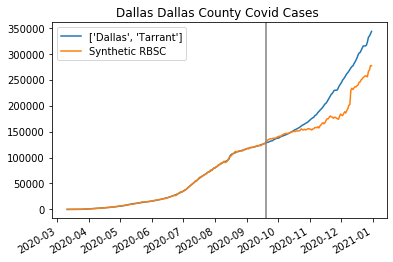

In [521]:
create_synthetic_graph("Dallas",["Dallas", "Tarrant"], ["TX"], ["09/20/2020"], True)

Our final Kept singular values
9


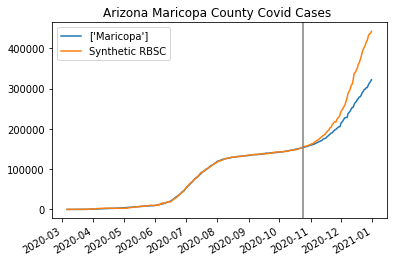

Our final Kept singular values
5


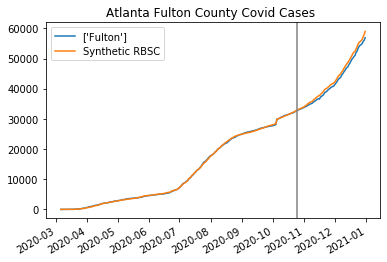

Our final Kept singular values
4


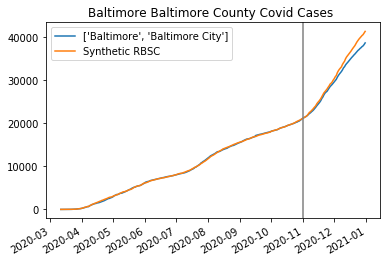

Our final Kept singular values
9


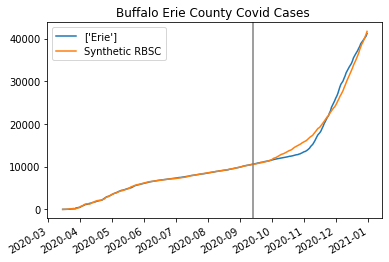

Our final Kept singular values
4


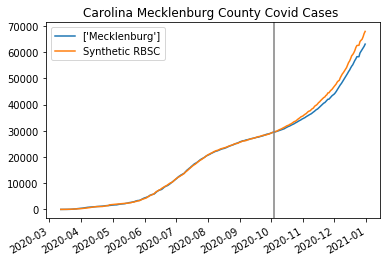

Our final Kept singular values
3


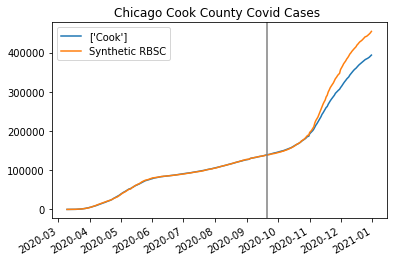

Our final Kept singular values
12


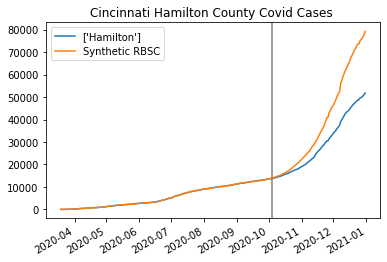

Our final Kept singular values
15


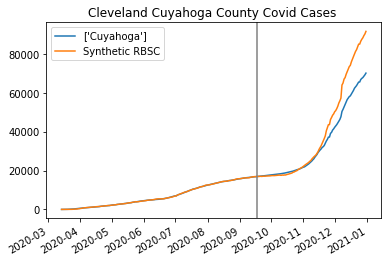

Our final Kept singular values
25


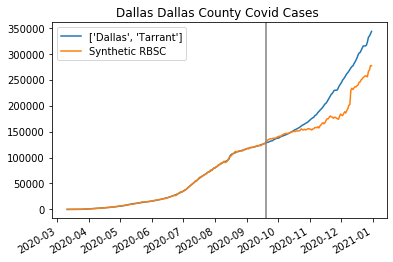

Our final Kept singular values
6


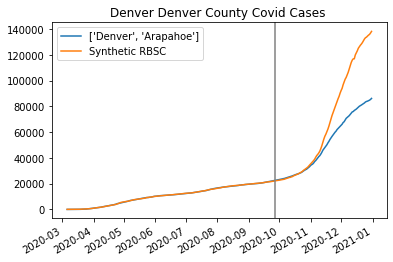

Our final Kept singular values
12


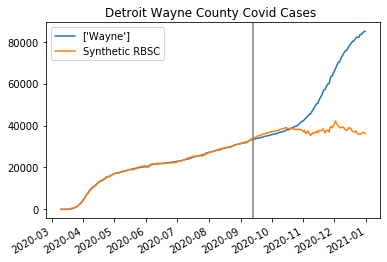

Uses all singular values
Our final Kept singular value
17


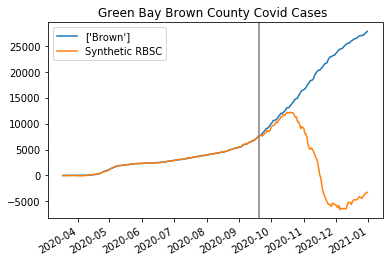

Our final Kept singular values
14


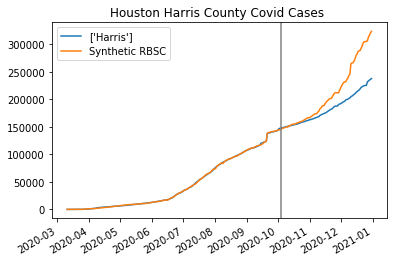

Our final Kept singular values
9


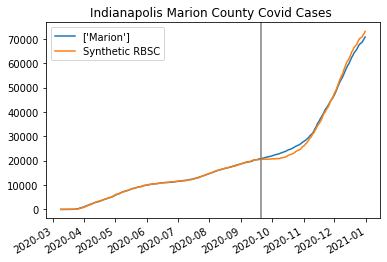

Our final Kept singular values
9


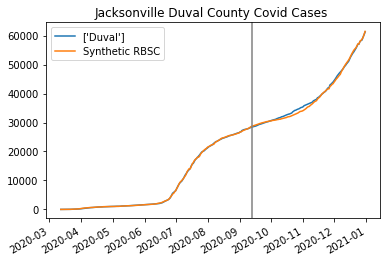

Our final Kept singular values
25


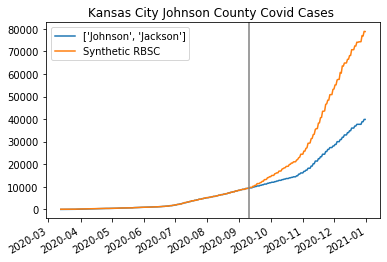

Our final Kept singular values
6


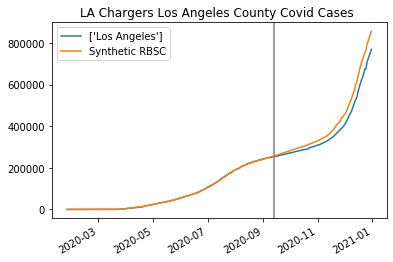

Our final Kept singular values
6


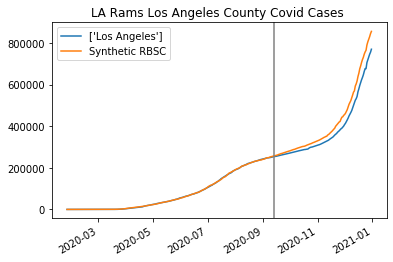

Uses all singular values
Our final Kept singular value
6


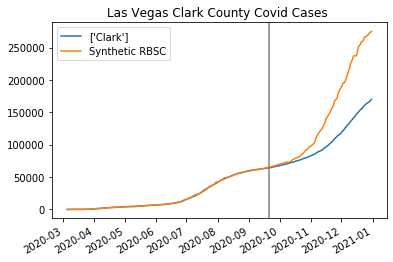

Our final Kept singular values
8


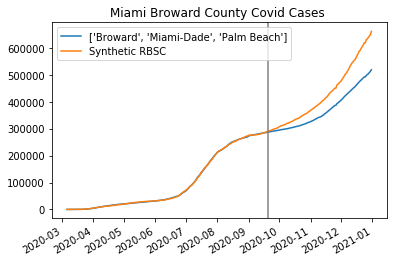

Our final Kept singular values
6


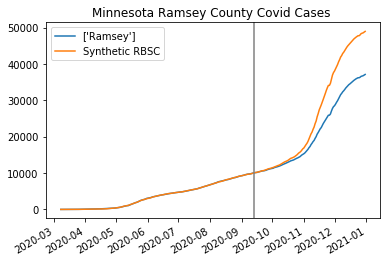

Our final Kept singular values
3


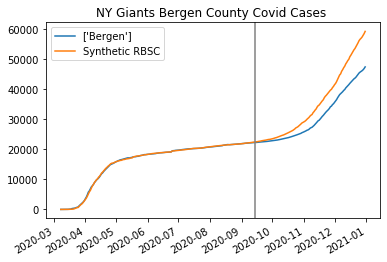

Our final Kept singular values
3


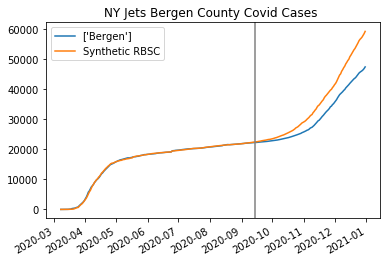

Our final Kept singular values
5


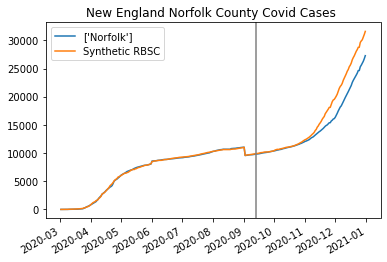

Our final Kept singular values
13


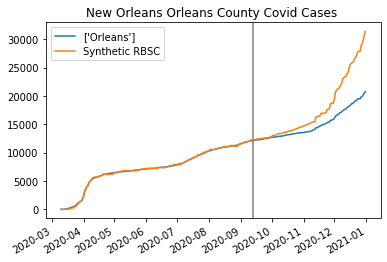

Our final Kept singular values
5


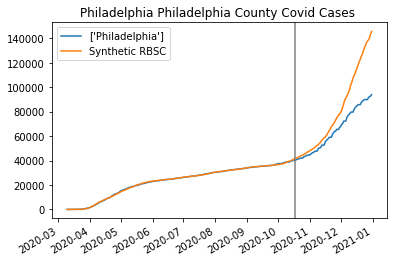

Our final Kept singular values
25


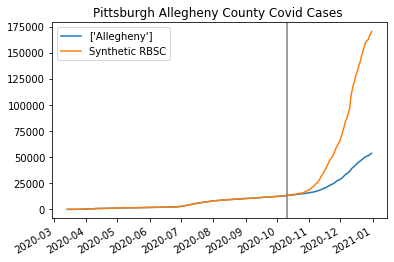

Uses all singular values
Our final Kept singular value
36


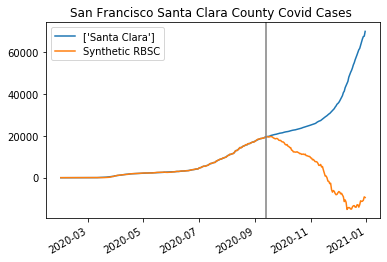

Uses all singular values
Our final Kept singular value
5


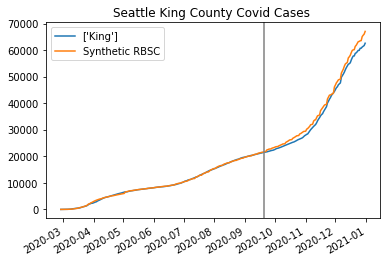

Our final Kept singular values
10


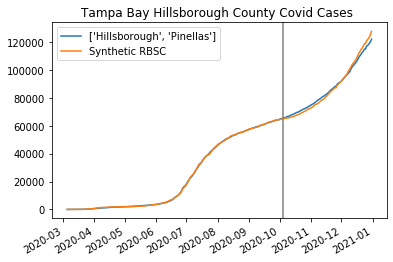

Our final Kept singular values
17


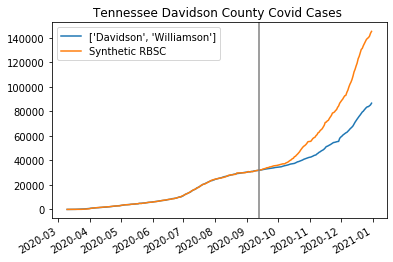

In [517]:
#Compute graphs for all combinations 

no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
Total_prediction_data_fans = []
Total_prediction_data_no_fans = []
dropped_stadium_df = stadium_county_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)


#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set



#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# for i, (team, county, state, date) in enumerate(zipped_input):
#     if (team != 'Washington'):
#         create_synthetic_graph(team, county, state, date)
    
for i, (team, county, state, date) in enumerate(zipped_input):
    if (team != 'Washington'):
        create_synthetic_graph(team, county, state, date, True)


In [471]:
#Make earlier function to be able to graph weeks 1-6 before the intervention. 
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']

def create_synthetic_lines(team_name_str, stadium_county_str, state_str, intervention_date):
    intervention_date = [x for x in intervention_date if x != ""]
    
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s
            
    intervention_date = pd.to_datetime(intervention_date)
    intervention_array = [intervention_date - datetime.timedelta(weeks=i) for i in range(1, 7)]
    print(team_name_str)
    for intervention in intervention_array: 
        intervention = intervention.strftime('%m/%d/%Y')
        l = []
        l.append(intervention)
        l.append("")
        create_synthetic_graph(team_name_str, stadium_county_str, state_str, l, False)

    plt.show()
    
    return 


['9/13/2020']
San Francisco
Uses all singular values
Our final Kept singular value
35
Uses all singular values
Our final Kept singular value
36
Uses all singular values
Our final Kept singular value
36
Uses all singular values
Our final Kept singular value
37
Uses all singular values
Our final Kept singular value
40
Uses all singular values
Our final Kept singular value
23


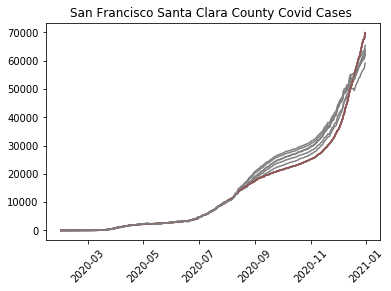

In [472]:
#Compute graphs for all combinations 

dropped_stadium_df = stadium_county_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)

#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['10/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# for i, (team, county, state, date) in enumerate(zipped_input):
#     if (team != 'Washington'):
#         create_synthetic_graph(team, county, state, date)
    
for i, (team, county, state, date) in enumerate(zipped_input):
    if (team == 'San Francisco'):
        print(date)
        create_synthetic_lines(team, county, state, date)


In [ ]:
#create_synthetic_lines("Kansas City",["Johnson", "Jackson"], ["KS", "MO"], ["09/10/2020"])

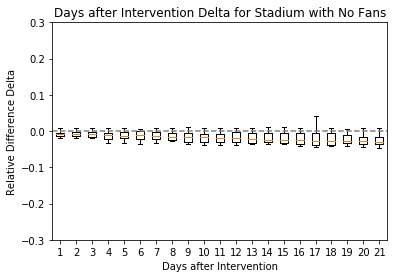

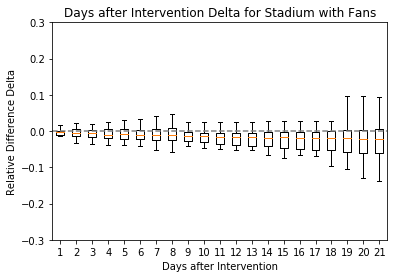

In [397]:
#Create graphs for results after Game day. 

#Total_prediction_data should have



assert np.array(Total_prediction_data_no_fans).shape == (14, 21) #NUmber of teams, number of days past intervention
assert np.array(Total_prediction_data_fans).shape == (17, 21)

IQR_list = []

Time_series_no_fans = np.array(Total_prediction_data_no_fans).T #Transpose of time series data
Time_series_fans = np.array(Total_prediction_data_fans).T

# q1, q3 = np.percentile(Time_series, [25, 75], axis=1)
# iqr = q3 - q1

# print(q1)
# print(q3)

#plt.fill_betweenx(np.arange(len(iqr)), q1, q3, color='b', alpha=0.2)
fig, ax = plt.subplots()

plt.boxplot(Time_series_no_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top = 0.3)
plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with No Fans")
ax.axhline(0, color='grey', linestyle='--')

# Show the plot
plt.show()

fig,ax = plt.subplots()

plt.boxplot(Time_series_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top=0.3)

plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with Fans")
ax.axhline(0, color='grey', linestyle='--')
plt.show()
    